In [35]:
import sys
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt
from PySide6.QtWidgets import QApplication
from temgymbasic.gui import TemGymWindow

import numpy as np
from temgymbasic.utils import calculate_phi_0
from temgymbasic import gbd

from typing import Tuple, NamedTuple
from temgymbasic.plotting import plot_model
%matplotlib ipympl

In [36]:
n_rays = 10000
wavelength = 0.1
wavelength = 0.01
k = 2 * np.pi / wavelength

wavelengths = np.full(n_rays, wavelength)

a = 10
b = 5

size = 1000
det_shape = (size, size)
pixel_size = 1 / size
dsize = det_shape[0] * pixel_size

x_det = np.linspace(-dsize / 2, dsize / 2, size)

theta_x = 0
theta_y = 0

deg_yx = np.deg2rad((theta_y, theta_x ))
tilt_yx = np.tan(deg_yx)

wo = 0.1
wos = np.full(n_rays, wo)

div = wavelength / (np.pi * wo)

dPx = wo
dPy = wo
dHx = div
dHy = div

z_r = (np.pi * wo ** 2) / wavelengths 

x0 = 0.1
y0 = 0

coeffs = [1, 0, 0, 0, 0]

In [37]:
components = (
    # comp.PointBeam(
    #     z=0.0,
    #     voltage=calculate_phi_0(wavelength),
    #     semi_angle = 0.01,
    #     tilt_yx=tilt_yx
    # ),
    comp.GaussBeam(
        z=0.0,
        voltage=calculate_phi_0(wavelength),
        radius=x0,
        wo=wo,
        tilt_yx=tilt_yx
    ),
    # comp.PerfectLens(
    #     z = a,
    #     f = 10,
    #     z1 = -a,
    #     z2 = b,
    # ),
    comp.AberratedLens(
        z = a,
        f = 10,
        z1 = -a,
        z2 = b,
        coeffs=coeffs,
    ),
    comp.AccumulatingDetector(
        z=a + b,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=64,
    ),
)

In [38]:
model = Model(components)
rays = tuple(model.run_iter(num_rays=n_rays))
image = model.detector.get_image(rays[-1])
det_x = np.linspace(-det_shape[1]//2*pixel_size, det_shape[1]//2*pixel_size, det_shape[1])

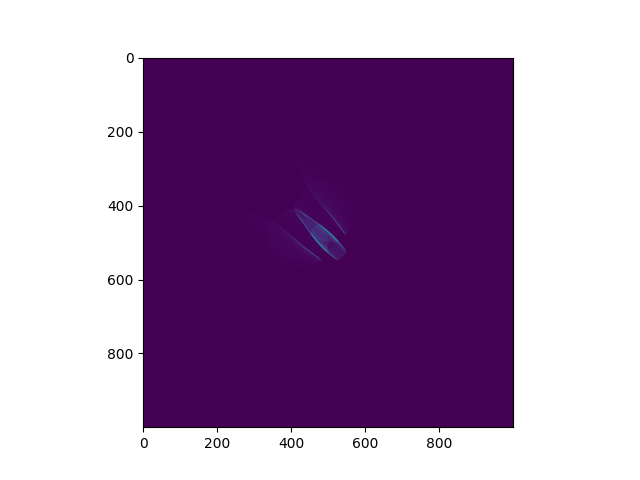

In [39]:
plt.figure()
plt.imshow(image)

In [ ]:
Qinv = gbd.calculate_Qinv(z_r)
Qpinv = gbd.calculate_Qpinv(A, B, C, D, Qinv)
field = gbd.propagate_misaligned_gaussian(Qinv, Qpinv, r, p2m.T, k, A, B, path_length).reshape(det_shape)
field = zero_phase(field, size//2, size//2)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.abs(field),cmap='gray')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
ax2.imshow(np.angle(field),cmap='RdBu')
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
fig.suptitle("GBP")